In [3]:
import numpy as np
import matplotlib.pyplot as plt


class Map:
    
    def __init__(self, pos: tuple, shape: tuple, scale: float) -> None:
        self.pos = np.array(pos, dtype=np.int16)
        self.array = np.zeros(shape, dtype=np.uint16)
        self.scale = scale
    
    
    def __contains__(self, value) -> bool:
        i = np.array(value)
        low, high = self.limits()
        return all(i >= low) and all(i < high)
    
    
    def __getitem__(self, key) -> int | np.ndarray:
        if key not in self:
            raise IndexError(f'За границами карты {key}')
        i = np.array(key)
        index = i - self.pos[:i.size]
        return self.array[*index]
    
    
    def __setitem__(self, key, value: int):
        if key not in self:
            raise IndexError(f'За границами карты {key}')
        i = np.array(key)
        index = i - self.pos[:i.size]
        self.array[*index] = value
    
    
    def limits(self) -> tuple[np.ndarray, np.ndarray]:
        return self.pos, self.pos + self.array.shape
    
    
    def update(self, other):
        if self.scale != other.scale:
            raise ValueError(f'Масштаб карт при сложении отличается: {self.scale} и {other.scale}')
        low1, high1 = self.limits()
        low2, high2 = other.limits()
        new_pos = np.min(np.vstack((low1, low2)), axis=0)
        new_high = np.max(np.vstack((high1, high2)), axis=0)
        new_array = np.zeros(new_high-new_pos, dtype=np.uint16)
        new_array[*[slice(l, h) for l, h in zip(low1-new_pos, low1-new_pos + np.array(self.array.shape))]] += self.array
        new_array[*[slice(l, h) for l, h in zip(low2-new_pos, low2-new_pos + np.array(other.array.shape))]] += other.array
        self.pos = new_pos
        self.array = new_array
        

    def show(self):
        x_min, y_max, x_max, y_min = np.concatenate(self.limits())*self.scale
        plt.imshow(self.array, cmap='gray_r', extent=[y_max, y_min, x_max, x_min])
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.grid(which='both')


def new_measurement(coords: np.ndarray, data: np.ndarray, scale: float) -> Map:
    x, y, rot = coords
    angle = np.linspace(-2*np.pi/3, 2*np.pi/3, len(data))
    data[data == 5.6] = np.nan
    data[data < 0.3] = np.nan
    xs = np.array([x + data * np.cos(rot-angle)]).transpose()
    ys = np.array([y + data * np.sin(rot-angle)]).transpose()
    points = np.hstack((xs, ys))
    points = points[~np.isnan(points).any(axis=1)]
    decomposed = (points // np.array([scale, scale])).astype(np.int16)
    decoposed_coords, counts = np.unique(decomposed, axis=0, return_counts=True)
    x_min, y_min, x_max, y_max = *decoposed_coords.min(axis=0), *decoposed_coords.max(axis=0)
    size = np.array([x_max - x_min + 1, y_max - y_min + 1])
    TOPLEFT = np.array([x_min, y_min])
    cell_map = np.zeros(size, dtype=np.uint16)
    for coord, n in zip(decoposed_coords, counts):
        cell_map[*(coord-TOPLEFT)] = n
    cell_map = cell_map.transpose()
    obj = Map(tuple(reversed(TOPLEFT)), cell_map.shape, scale)
    obj.array = cell_map
    return obj

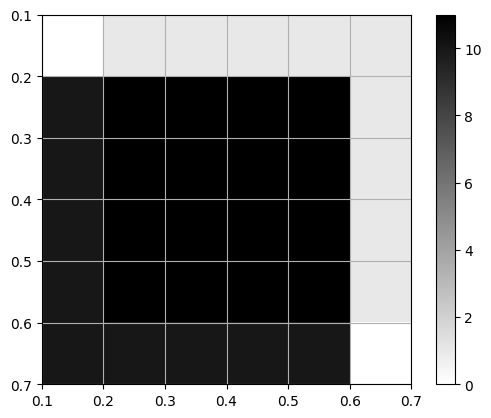

In [88]:
a = Map((1, 2), (5, 5), 0.1)
b = Map((2, 1), (5, 5), 0.1)
a.array += 1
b.array += 10
a.update(b)
a.show()

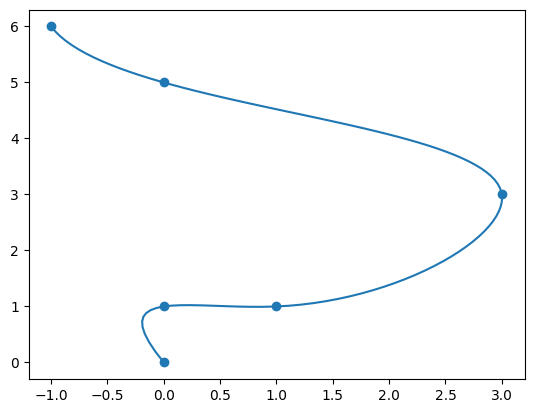

In [57]:
import numpy as np
import scipy.interpolate as interp

def interpolate_polyline(polyline, num_points):
    tck, u = interp.splprep(polyline.T, s=0)
    u = np.linspace(0.0, 1.0, num_points)
    return np.array(interp.splev(u, tck)).transpose()

A = np.array([[0, 0], [0, 1], [1, 1], [3, 3], [0, 5], [-1, 6]])

B = interpolate_polyline(A, 100)
plt.plot(*B.transpose())
plt.scatter(*A.transpose())

In [3]:
import numpy as np

trajectory = [np.array([0, 0]),
              np.array([0, 1]),
              np.array([2, 2]),
              np.array([4, 5]),
              np.array([6, 6])]


np.vstack([np.linspace(trajectory[i], point, 5, endpoint=False) for i, point in enumerate(trajectory[1:])])

array([[0. , 0. ],
       [0. , 0.2],
       [0. , 0.4],
       [0. , 0.6],
       [0. , 0.8],
       [0. , 1. ],
       [0.4, 1.2],
       [0.8, 1.4],
       [1.2, 1.6],
       [1.6, 1.8],
       [2. , 2. ],
       [2.4, 2.6],
       [2.8, 3.2],
       [3.2, 3.8],
       [3.6, 4.4],
       [4. , 5. ],
       [4.4, 5.2],
       [4.8, 5.4],
       [5.2, 5.6],
       [5.6, 5.8]])

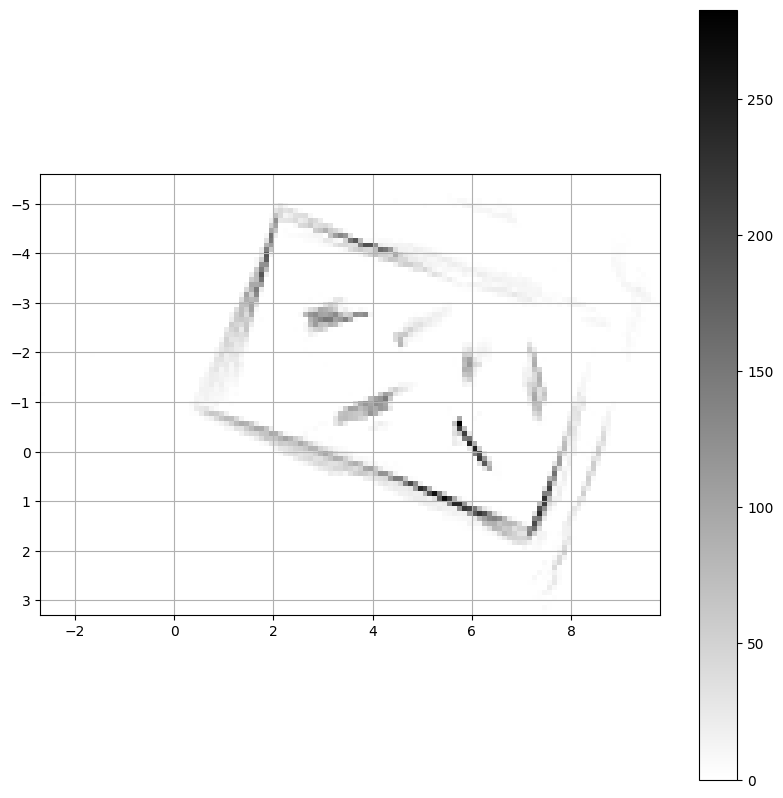

In [5]:
SCALE = 0.1

plt.figure(figsize=(10, 10))
with open("examples/examp7.txt") as file:
    for i, line in enumerate(file):
        c, d = line.split("; ")
        coords = np.array([float(number) for number in c.split(", ")])
        data = np.array([float(number) for number in d.split(", ")])
        if i == 0:
            a = new_measurement(coords, data, SCALE)
        else:
            a.update(new_measurement(coords, data, SCALE))
a.show()

Scheme viz

In [2]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import schematics

class Sim:
    '''Represents sim. Use Sim.sim.{command}() to send commands to sim.'''
    
    client = RemoteAPIClient()
    sim = client.getObject('sim')
    client.setStepping(False)
    verbose = True  


scheme = schematics.open_scheme('schemes/default_scheme.json')

for coords, rot, shape in scheme.iterator():
    cube = Sim.sim.createPrimitiveShape(Sim.sim.primitiveshape_cuboid, list(shape))
    Sim.sim.setObjectPosition(cube, Sim.sim.handle_world, list(coords))
    Sim.sim.setObjectOrientation(cube, Sim.sim.handle_world, [0, 0, rot])

ModuleNotFoundError: No module named 'schematics'

In [6]:
def convert_from_uvd(u, v, d, f, c):
    x = (u - c[1]) * d / f
    y = (v - c[0]) * d / f
    z = d
    return np.array([x, y, z])
    

def new_measurement(coords: np.ndarray, data: np.ndarray, scale: float) -> Map:
    x, y, rot = coords
    angle = np.linspace(3*np.pi/8, -3*np.pi/8, len(data))
    data /= np.cos(angle)
    xs = np.array([x + data * np.cos(rot-angle)]).transpose()
    ys = np.array([y + data * np.sin(rot-angle)]).transpose()
    points = np.hstack((xs, ys))
    points = points[~np.isnan(points).any(axis=1)]
    decomposed = (points // np.array([scale, scale])).astype(np.int16)
    decoposed_coords, counts = np.unique(decomposed, axis=0, return_counts=True)
    x_min, y_min, x_max, y_max = *decoposed_coords.min(axis=0), *decoposed_coords.max(axis=0)
    size = np.array([x_max - x_min + 1, y_max - y_min + 1])
    TOPLEFT = np.array([x_min, y_min])
    cell_map = np.zeros(size, dtype=np.uint16)
    for coord, n in zip(decoposed_coords, counts):
        cell_map[*(coord-TOPLEFT)] = n
    cell_map = cell_map.transpose()
    obj = Map(tuple(reversed(TOPLEFT)), cell_map.shape, scale)
    obj.array = cell_map
    return obj

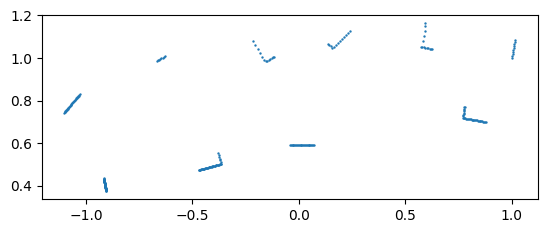

In [30]:
import struct
import time
SCALE = 0.01

Sim.sim.startSimulation()
time.sleep(0.5)
lidar = Sim.sim.getObject('/youBot/Lidar')
cloud = np.empty((3, 0))

start = time.time()
# while time.time()-start < 5:
depth, res = Sim.sim.getVisionSensorDepth(lidar)
pos = Sim.sim.getObjectPosition(lidar, Sim.sim.handle_world)
azimuth = Sim.sim.getObjectOrientation(lidar, Sim.sim.handle_world)
d = [struct.unpack('f', depth[i:i+4])[0] for i in range(0, len(depth), 4)]
data = np.array(d).reshape(res)
data[data > 0.99] = np.nan
data = data * (2 - 1e-4) + 1e-4
cloud = np.array([convert_from_uvd(u, v, data[v, u], data.shape[1]/2/np.tan(3*np.pi/8), np.array(data.shape)/2) for u in range(data.shape[1]) for v in range(data.shape[0])]).transpose()
cloud = cloud[:, ~np.isnan(cloud).any(axis=0)]

Sim.sim.stopSimulation()

plt.gca().set_aspect('equal')
plt.scatter(*cloud[[0, 2]], s=0.5)

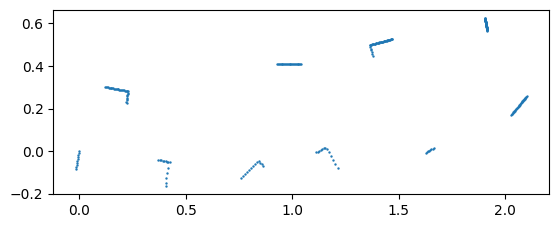

In [31]:
a = np.pi
matrix_z = np.array([[np.cos(a), -np.sin(a), 0.],
                     [np.sin(a), np.cos(a), 0.],
                     [0., 0., 1.]])

x, y, z = cloud
global_cloud = np.array([x, z, y])
cloud = (np.dot(global_cloud.transpose(), matrix_z) + np.array([1, 1, 0])).transpose()
plt.gca().set_aspect('equal')
plt.scatter(*cloud[:2], s=0.5)

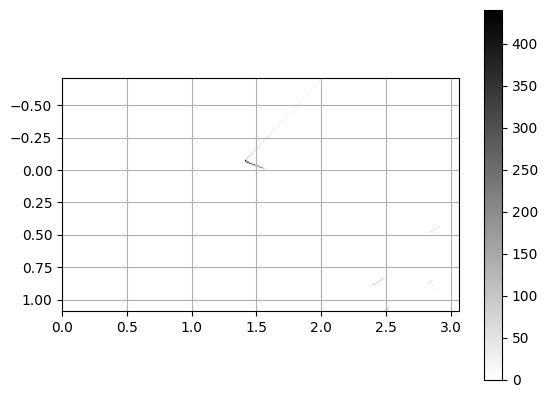

In [45]:
import struct
import time
start = time.time()
SCALE = 0.01

Sim.sim.startSimulation()
lidar = Sim.sim.getObject('/youBot/Lidar')
world_map = Map(Sim.sim.getObjectPosition(lidar, Sim.sim.handle_world)[:2], (0, 0), SCALE)

while time.time()-start < 5:
    depth, res = Sim.sim.getVisionSensorDepth(lidar)
    pos = Sim.sim.getObjectPosition(lidar, Sim.sim.handle_world)
    azimuth = Sim.sim.getObjectOrientation(lidar, Sim.sim.handle_world)
    d = [struct.unpack('f', depth[i:i+4])[0] for i in range(0, len(depth), 4)]
    data = np.array(d).reshape(res[1])*2 + 1e-04
    data[data > 1.9] = np.nan
    if np.isnan(data).all():
        continue
    world_map.update(new_measurement(coords, data, SCALE))
    time.sleep(0.1)

Sim.sim.stopSimulation()

world_map.show()

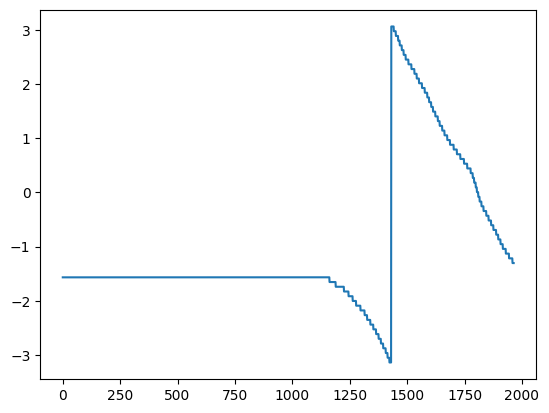

In [11]:
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import matplotlib.pyplot as plt

class Sim:
    '''Represents sim. Use Sim.sim.{command}() to send commands to sim.'''
    
    client = RemoteAPIClient()
    sim = client.getObject('sim')
    client.setStepping(False)
    verbose = True
      
Sim.sim.startSimulation()
ref = Sim.sim.getObject('./youBot_ref')
start = time.time()
angle = []
while time.time() - start < 10:
    angle.append(Sim.sim.getObjectOrientation(ref, Sim.sim.handle_world)[2])
Sim.sim.stopSimulation()
plt.plot(angle)

In [10]:
from kuka import *
from time import sleep

Sim.sim.startSimulation()
sleep(0.2)
robot = assemble_robot()
start = robot.platform.ref.get_pos()
robot.platform.travel_to((0., 1.5))
robot.platform.travel_to((0., 0.))
robot.platform.travel_to((2., 2.))
robot.platform.travel_to((1., 2.))
robot.platform.travel_to(start)
Sim.sim.stopSimulation()

Azimuth delta: 0.9682438700926401
Azimuth: -0.1822806610853256
Target: 0.7859632090073145

Azimuth delta: 0.9682369608366101
Azimuth: -0.18227375182929562
Target: 0.7859632090073145

Azimuth delta: 0.9682369608366101
Azimuth: -0.18227375182929562
Target: 0.7859632090073145

Azimuth delta: 0.9522508718512508
Azimuth: -0.16628766284393626
Target: 0.7859632090073145

Azimuth delta: 0.9522508718512508
Azimuth: -0.16628766284393626
Target: 0.7859632090073145

Azimuth delta: 0.9522508718512508
Azimuth: -0.12895205076279925
Target: 0.7859632090073145

Azimuth delta: 0.9149152597701138
Azimuth: -0.12895205076279925
Target: 0.7859632090073145

Azimuth delta: 0.9149152597701138
Azimuth: -0.08516593876903356
Target: 0.7859632090073145

Azimuth delta: 0.8711291477763481
Azimuth: -0.08516593876903356
Target: 0.7859632090073145

Azimuth delta: 0.8711291477763481
Azimuth: -0.08516593876903356
Target: 0.7859632090073145

Azimuth delta: 0.8274637145701853
Azimuth: -0.04150050556287077
Target: 0.7859632

1

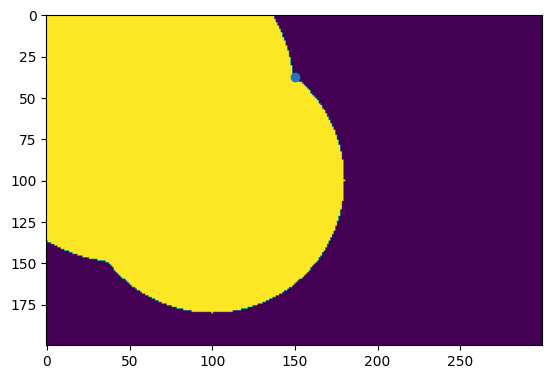

In [9]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt

bitmap = np.zeros((200, 300))
cv2.circle(bitmap, (50, 50), 100, 1, -1) # type: ignore
cv2.circle(bitmap, (100, 100), 80, 1, -1) # type: ignore
plt.imshow(bitmap)
target = np.array([100, 75])

bitmap = bitmap.transpose().astype(bool)
reachable_points = np.stack(np.meshgrid(np.arange(bitmap.shape[1]), np.arange(bitmap.shape[0])), axis=-1)[~bitmap].reshape(-1, 2)
if len(reachable_points) == 0:
    raise ValueError('No reachable points')
closest = min(reachable_points, key=lambda p: np.linalg.norm(target-p))
plt.scatter(*closest)

array([12.,  0.])

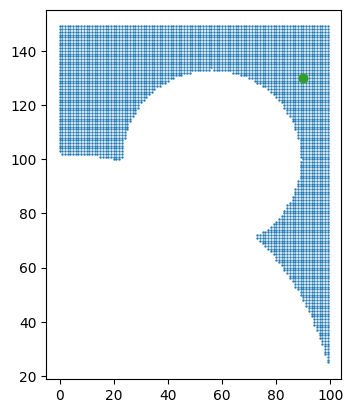

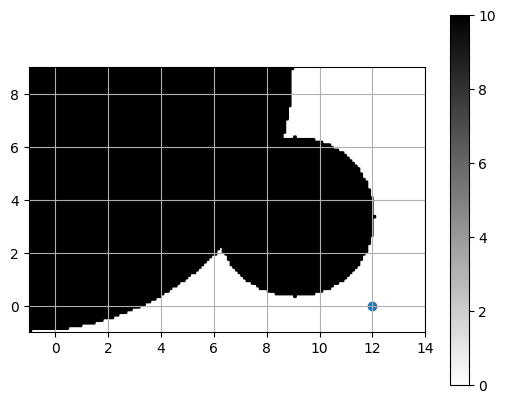

In [4]:
from navigation import Map
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt

M = Map((-10., -10.), (100, 150), 0.1)
img = M.array.astype(int)
cv2.circle(img, (0, 0), 99, 25, -1) # type: ignore
cv2.circle(img, (100, 56), 30, 25, -1) # type: ignore
M.array = img.astype(np.uint32)

closest = M.find_closest_to(np.array([12., 0.]))
plt.figure()
M.show()
plt.scatter(*closest)
closest

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


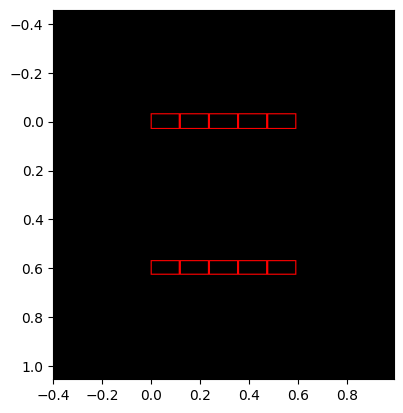

In [3]:
from schematics import *

scheme = open_scheme('schemes/parallel_scheme.json')
scheme.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def to_decart(q: np.ndarray, joint: int = 5) -> np.ndarray:
    return q

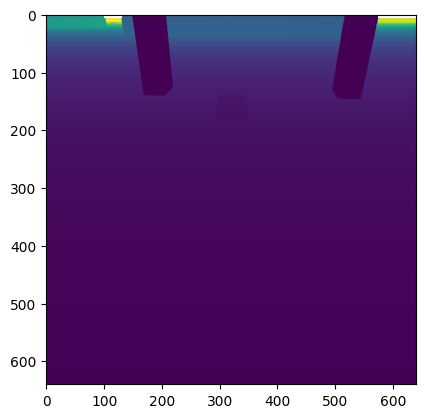

shape:  (640, 640)


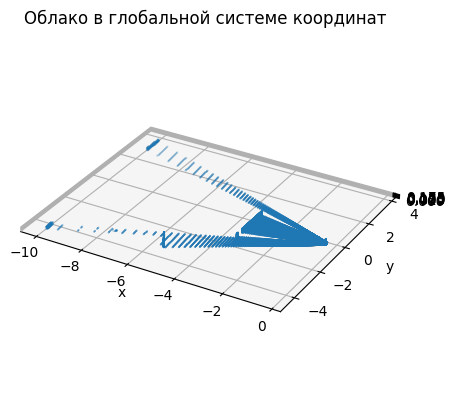

1

In [6]:
import matplotlib.pyplot as plt
from kuka import *
from time import sleep

Sim.sim.startSimulation()
sleep(0.5)
pc = Sim.sim.getObject('/PointCloud')
camera = VisionSensor(f'/youBot/Vision_sensor', Angle(60, True), (640, 640), 1e-4, 10.)
cloud = camera.get_cloud()
# for point in cloud.transpose():
#     Sim.sim.insertPointsIntoPointCloud(pc, 0, list(point))
Sim.sim.stopSimulation()

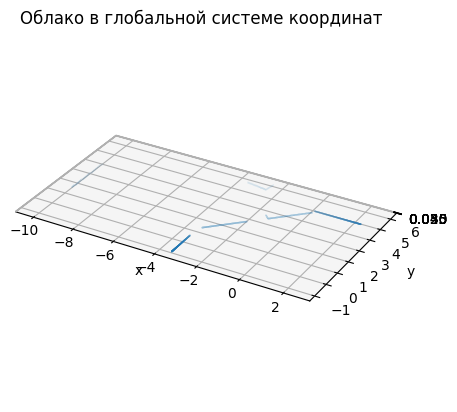

1

In [1]:
import matplotlib.pyplot as plt
from kuka import *
from time import sleep

Sim.sim.startSimulation()
sleep(0.5)
pc = Sim.sim.getObject('/PointCloud')
lidar = VisionSensor(f'/youBot/Lidar', Angle(135, True), (1, 680), 1e-4, 10.)
cloud = lidar.get_cloud()
# for point in cloud.transpose():
#     Sim.sim.insertPointsIntoPointCloud(pc, 0, list(point))
Sim.sim.stopSimulation()

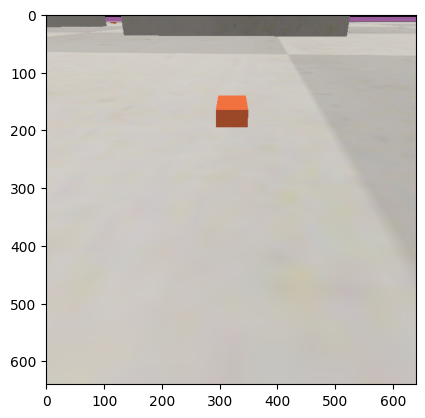

1

In [1]:
import matplotlib.pyplot as plt
from kuka import *
from time import sleep

Sim.sim.startSimulation()
sleep(0.5)
camera = VisionSensor(f'/youBot/Vision_sensor', Angle(60, True), (640, 640), 1e-4, 10.)
camera.shoot(True)
Sim.sim.stopSimulation()

In [1]:
from kuka import *
from main import Vision
from multiprocessing import Queue

Sim.sim.startSimulation()
sleep(0.5)
camera = VisionSensor(f'/youBot/Vision_sensor', Angle(60, True), (640, 640), 1e-4, 10.)
viz = Vision(Sim.lock, Queue()).scan()
Sim.sim.stopSimulation()

pygame-ce 2.4.0 (SDL 2.28.5, Python 3.11.5)


c:\Coding\Pathfinding\Navigation\main.py:59: RuntimeWarning: overflow encountered in scalar add
  mask = np.array([[pixel[2] < pixel[0] + pixel[1] for pixel in row] for row in cut_rgb], dtype=bool).flatten()


ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 0
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 4
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin s

KeyboardInterrupt: 

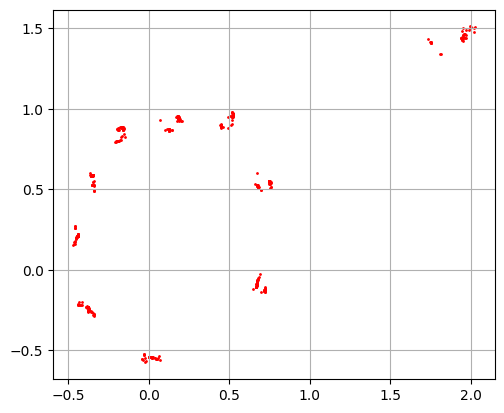

In [5]:
import numpy as np
import matplotlib.pyplot as plt

with open('detection_points.log', 'r') as f:
    data = np.array(list(map(float, f.read().split()))).reshape(-1, 4)
plt.scatter(data[:, 0], data[:, 1], s=1, c='r')
plt.grid()
plt.gca().set_aspect('equal')

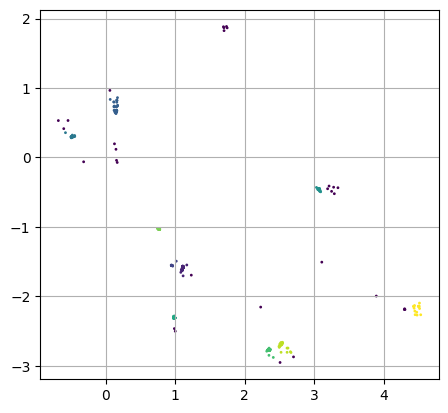

In [3]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.1, min_samples=10).fit_predict(data[:, :2])
plt.scatter(*data[:, :2].transpose(), s=1, c=clusters)
plt.gca().set_aspect('equal')
plt.grid()


Cluster 0:
[ 1.1079033 -1.5820622]

Cluster 1:
[ 0.95032553 -1.55424589]

Cluster 2:
[0.14897823 0.67151448]

Cluster 3:
[-0.48879264  0.29919771]

Cluster 4:
[ 3.06972579 -0.45454515]

Cluster 5:
[ 0.98414409 -2.31010166]

Cluster 6:
[ 2.35050911 -2.77482068]

Cluster 7:
[ 0.76423923 -1.0292303 ]

Cluster 8:
[ 2.52004423 -2.68830646]

Cluster 9:
[ 4.48078499 -2.14744284]


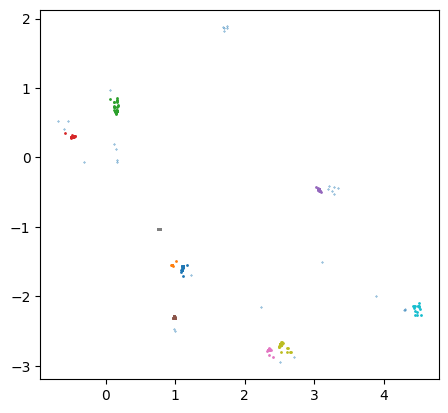

In [4]:
medians = []
means = []
for cluster in set(clusters):
    cloud = data[clusters == cluster, :2]
    if cluster == -1:
        plt.scatter(*cloud.transpose(), s=0.1)
        continue
    plt.scatter(*cloud.transpose(), s=1)
    print(f'\nCluster {cluster}:')
    print(np.median(cloud, axis=0))
    medians.append(np.median(cloud, axis=0))
    means.append(np.mean(cloud, axis=0))
plt.gca().set_aspect('equal')
medians = np.array(medians)
means = np.array(means)

In [4]:
from kuka import *

bricks = [Sim.sim.getObject(f'/Brick{i}') for i in range(1, 11)]
pos = np.array([Sim.sim.getObjectPosition(brick, Sim.sim.handle_world)[:2] for brick in bricks])
print("means error:")
for num in np.linalg.norm(pos[pos[:, 0].argsort()] - means[means[:, 0].argsort()], axis=1):
    print(f'{num:.3f}')
    
print("medians error:")
for num in np.linalg.norm(pos[pos[:, 0].argsort()] - medians[medians[:, 0].argsort()], axis=1):
    print(f'{num:.3f}')

means error:
0.181
0.223
0.137
1.945
0.061
0.105
1.862
3.364
0.119
0.011
medians error:
0.188
0.212
0.145
1.952
0.069
0.023
1.859
3.366
0.129
0.009


2D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2


def rotate2D(origin: tuple[float, float], cloud: np.ndarray, angle: float) -> np.ndarray:
    assert cloud.shape[0] == 2, 'wrong input shape'

    ox, oy = origin
    px, py = cloud

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return np.array([qx, qy])


def dist_points2line(points: np.ndarray, line: tuple[float, float, float]) -> np.ndarray:
    assert points.shape[0] == 2, 'wrong input shape'
    a, b, c = line
    return np.abs(a*points[0] + b*points[1] + c) / np.sqrt(a**2 + b**2)


def dist_points2plane(points: np.ndarray, plane: tuple[float, float, float, float]) -> np.ndarray:
    assert points.shape[0] == 3, 'wrong input shape'
    a, b, c, d = plane
    return np.abs(a*points[0] + b*points[1] + c*points[2] + d) / np.sqrt(a**2 + b**2 + c**2)
    
    
def line_by_2_points(points) -> tuple[float, float, float]:
    assert len(points) == 2
    p1, p2 = points
    a = p1[1] - p2[1]
    b = p2[0] - p1[0]
    c = p1[0]*p2[1] - p1[1]*p2[0]
    return a, b, c


def plane_by_3_points(points) -> tuple[float, float, float, float]:
    assert len(points) == 3
    p1, p2, p3 = points
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    x3, y3, z3 = p3
    a1 = x2 - x1
    b1 = y2 - y1
    c1 = z2 - z1
    a2 = x3 - x1
    b2 = y3 - y1
    c2 = z3 - z1
    a = b1 * c2 - b2 * c1
    b = a2 * c1 - a1 * c2
    c = a1 * b2 - b1 * a2
    d = - a * x1 - b * y1 - c * z1
    return a, b, c, d


def iteration2D(cloud: np.ndarray, precision: float = 0.01) -> tuple[int, tuple[float, float, float]]:
    seed = cloud[:, np.random.randint(0, cloud.shape[1]-1, size=2)].transpose()
    line = line_by_2_points(seed)
    d = dist_points2line(cloud, line)
    return np.count_nonzero(d <= precision), line


def iteration3D(cloud: np.ndarray, precision: float = 0.01) -> tuple[int, tuple[float, float, float, float]]:
    seed = cloud[:, np.random.randint(0, cloud.shape[1]-1, size=3)].transpose()
    plane = plane_by_3_points(seed)
    d = dist_points2plane(cloud, plane)
    return np.count_nonzero(d <= precision), plane


def get_center3D(cloud: np.ndarray) -> np.ndarray:
    assert cloud.shape[0] == 3
    mins = np.min(cloud, axis=1)
    maxs = np.max(cloud, axis=1)
    return (maxs + mins) / 2

(-13.790317336109783, 8.258776234201356)

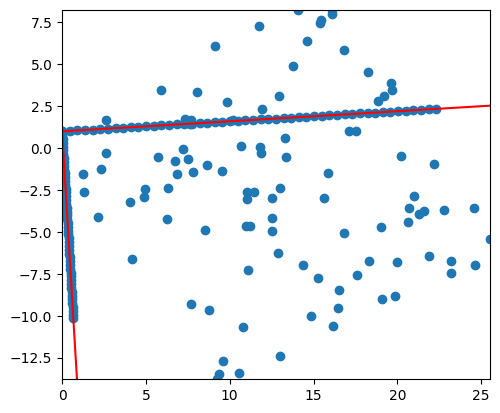

In [2]:
x = np.linspace(0, 10)
y1 = 2*x + 1
y2 = -0.5*x + 1
cloud = np.hstack((np.array([x, y1]), np.array([x, y2]), np.random.random((2, 100))*20))
cloud = rotate2D((0., 1.), cloud, -np.pi/3) 
f = lambda a1, a2, a3, x: (a1*x + a3)/-a2
d = dict(iteration2D(cloud) for _ in range(100))
line = d[max(d)]
d = dict(iteration2D(cloud[:, dist_points2line(cloud, line) > 0.1]) for _ in range(100))
line2 = d[max(d)]
x = np.array([np.min(cloud[0]), np.max(cloud[0])])
plt.scatter(*cloud)
plt.plot(x, f(*line, x), c='r')
plt.plot(x, f(*line2, x), c='r')
plt.gca().set_aspect('equal')
plt.xlim(*x)
plt.ylim([np.min(cloud[1]), np.max(cloud[1])])

In [3]:
def draw_cloud(cloud: np.ndarray):
    is_on_plane = lambda plane, points: dist_points2plane(points, plane) < 0.001

    planes = []

    step_1_cloud = cloud
    d = dict(iteration3D(step_1_cloud, precision=0.001) for _ in range(100))
    planes.append(d[max(d)])

    step_2_cloud = step_1_cloud[:, ~is_on_plane(planes[-1], step_1_cloud)]
    d = dict(iteration3D(step_2_cloud, precision=0.001) for _ in range(100))
    planes.append(d[max(d)])

    step_3_cloud = step_2_cloud[:, ~is_on_plane(planes[-1], step_2_cloud)]
    d = dict(iteration3D(step_3_cloud, precision=0.001) for _ in range(100))
    planes.append(d[max(d)])

    colors = np.array([is_on_plane(plane, cloud) for plane in planes])
    actual_cloud_i = np.any(colors, axis=0)
    center = get_center3D(cloud[:, actual_cloud_i])

    ax = plt.subplot(projection='3d')
    ax.scatter(*cloud[:, actual_cloud_i], s=0.1, c=colors[:, actual_cloud_i].astype(np.uint8).transpose())
    ax.scatter(*center, c='k')
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z') # type: ignore
    ax.view_init(20, -150)


0: 640x640 1 brick, 33.0ms
Speed: 3.0ms preprocess, 33.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


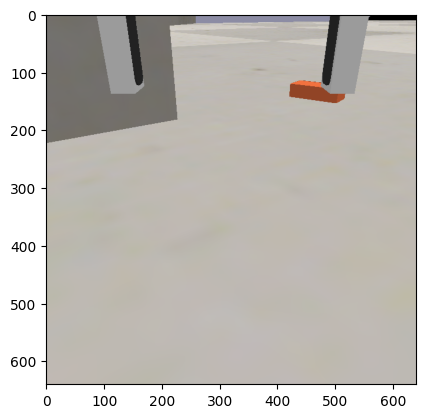

1

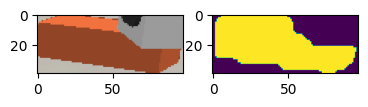

<Figure size 640x480 with 0 Axes>

In [100]:
from math import ceil
import cv2 as cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from main import Vision
from multiprocessing import Queue
from kuka import Sim

Sim.sim.startSimulation()
model = YOLO('yolo-seg-v3.pt')
viz = Vision(Sim.lock, Queue())

matrix, depth, img = viz.camera.shoot(do_rgb=True)
frame = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
results = model.predict(frame)
plt.imshow(img)
plt.show()
for result in results:
    for c in result[0]:
        conf = round(c.boxes.conf[0].item(), 2)
        if conf < 0.5:
            continue
        
        coords = [ceil(x) for x in c.boxes.xyxy.tolist()[0]]
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        c_mask = np.zeros(img.shape[:2], np.uint8)
        cv2.drawContours(c_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
        mask = c_mask[coords[1]:coords[3], coords[0]:coords[2]].astype(bool)
        cut_rgb = img[coords[1]:coords[3], coords[0]:coords[2]]
        cloud = viz.camera.get_cloud(depth, matrix, tuple(coords[:2]), tuple(coords[2:]))[:, mask.flatten()]
        fig = plt.figure()
        plt.subplot(131)
        plt.imshow(cut_rgb)
        plt.subplot(132)
        plt.imshow(mask)
        plt.figure()
Sim.sim.stopSimulation()

C:\Users\Green\AppData\Local\Temp\ipykernel_13100\1647682689.py:26: RuntimeWarning: invalid value encountered in divide
  return np.abs(a*points[0] + b*points[1] + c*points[2] + d) / np.sqrt(a**2 + b**2 + c**2)


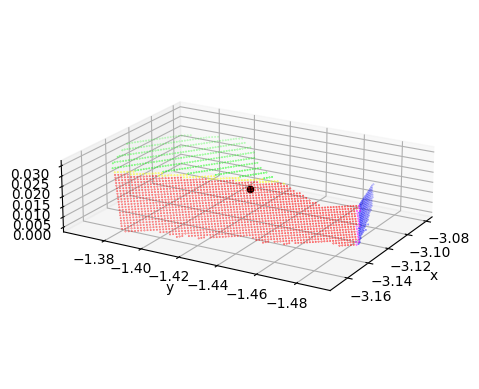

In [101]:
is_on_plane = lambda plane, points: dist_points2plane(points, plane) < 0.001

planes = []

step_1_cloud = cloud
d = dict(iteration3D(step_1_cloud, precision=0.001) for _ in range(100))
planes.append(d[max(d)])

step_2_cloud = step_1_cloud[:, ~is_on_plane(planes[-1], step_1_cloud)]
d = dict(iteration3D(step_2_cloud, precision=0.001) for _ in range(100))
planes.append(d[max(d)])

step_3_cloud = step_2_cloud[:, ~is_on_plane(planes[-1], step_2_cloud)]
d = dict(iteration3D(step_3_cloud, precision=0.001) for _ in range(100))
planes.append(d[max(d)])

colors = np.array([is_on_plane(plane, cloud) for plane in planes])
actual_cloud_i = np.any(colors, axis=0)
center = get_center3D(cloud[:, actual_cloud_i])
priority = np.count_nonzero(colors, axis=1)

ax = plt.subplot(projection='3d')
ax.scatter(*cloud[:, actual_cloud_i], s=0.1, c=colors[:, actual_cloud_i].astype(np.uint8).transpose())
ax.scatter(*center, c='k')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z') # type: ignore
ax.view_init(20, -150)

{(0, 1): True, (0, 2): True, (1, 2): True}


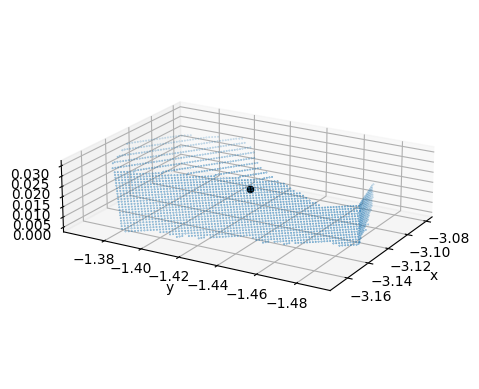

In [102]:
normales = np.array(planes)[:, :3] / np.linalg.norm(np.array(planes)[:, :3], axis=1, keepdims=True)
orthogonality = {(j, i) : np.abs(np.dot(normales[j], normales[i])) < .1 for j in range(0, 2) for i in range(j+1, 3)}
print(orthogonality)
conflicts = [key for key in orthogonality if ~orthogonality[key]]
match len(conflicts):
    case 0:
        pass
    case 1:
        planes.pop(conflicts[0][0] if priority[conflicts[0][0]] < priority[conflicts[0][1]] else conflicts[0][1])
    case 2:
        for plane in conflicts[0]:
            if plane in conflicts[1]: 
                planes.pop(plane)
                break
    case _:
        raise RuntimeError('no orthogonal faces')
    
colors = np.array([is_on_plane(plane, cloud) for plane in planes])
actual_cloud_i = np.any(colors, axis=0)
center = get_center3D(cloud[:, actual_cloud_i])

ax = plt.subplot(projection='3d')
ax.scatter(*cloud[:, actual_cloud_i], s=0.1)
ax.scatter(*center, c='k')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z') # type: ignore
ax.view_init(20, -150)

In [103]:
from collections import Counter
BRICK_DIMS = np.array([.05500, .11458, .02979])

dims = [2*dist_points2plane(center, plane) for plane in planes]
fitting_faces = [np.argmin(np.abs(BRICK_DIMS - dim)) for dim in dims]
conflict, count = Counter(fitting_faces).most_common(1)[0]
match count:
    case 3:
        raise ValueError(f'All faces pretend to be {conflict}')
    case 2:
        i = len(fitting_faces) - 1 - fitting_faces[::-1].index(conflict)
        fitting_faces[i] = (set(range(3)) - set(fitting_faces)).pop() # type: ignore
    case _:
        pass

basis = [[]]*3
for face, plane in zip(fitting_faces, planes):
    basis[face] = plane[:3]
match len(fitting_faces):
    case 1:
        raise ValueError(f'Not enough faces to create a basis: {len(fitting_faces)}')
    case 2:
        missing_dim = (set(range(3)) - set(fitting_faces)).pop() # type: ignore
        print(missing_dim)
        match missing_dim:
            case 2:
                basis[missing_dim] = list(np.cross(basis[0][:3], basis[1][:3]))
            case 1:
                basis[missing_dim] = list(np.cross(basis[2][:3], basis[0][:3]))
            case 0:
                basis[missing_dim] = list(np.cross(basis[1][:3], basis[2][:3]))
            case _:
                raise ValueError('Unexpected dim')
fitting_faces

[0, 2, 1]

In [104]:
basis = np.array(basis).transpose()
norm_basis = basis / np.linalg.norm(basis, axis=0)

if norm_basis[2, 2] < 0: 
    norm_basis *= -1
a, b, c = norm_basis.transpose()
if np.dot(a, np.cross(b, c)) < 0: # переход к правой тройке
    norm_basis = np.array([a, -b, c]).transpose()

global_basis = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
rot_matrix = np.dot(np.linalg.inv(norm_basis), global_basis)
rot_matrix

array([[   -0.94048,    -0.33998,  -0.0016914],
       [    0.33824,    -0.94111,  0.00037626],
       [ -0.0072784,   -0.012741,     0.99999]])

In [105]:
from scipy.spatial.transform import Rotation
from numpy import pi as PI   

r = Rotation.from_matrix(rot_matrix)
euler = -r.as_euler("xyz")
for num in center: print(f'{num:.3f}', end=' ')
print()
for num in euler: print(f'{num/PI*180:.3f}', end=' ')

-3.125 -1.427 0.015 
0.399 -0.195 -160.177 

In [106]:
from kuka import SimObject
brick = SimObject('./Brick9')
for num in brick.get_pos(): print(f'{num:.3f}', end=' ')
print()
for num in brick.get_orient(): print(f'{num/PI*180:.3f}', end=' ')

-3.125 -1.425 0.015 
-0.000 -0.000 -160.000 

In [107]:
# from clusters import *
# import matplotlib.pyplot as plt


# system = ClusterSystem()
# Cluster.SIZE = 1000

# for i in range(100000):
#     det = Detection(np.random.random(2), np.random.random()*2*PI, np.random.random())
#     system.add_item(det)

# for i, cluster in enumerate(system.clusters):
#     cloud = np.array([p.coords for p in cluster.points])[:, :2].transpose()
#     color = np.random.random(3)
#     plt.scatter(*cloud, s=1, c=color)
#     plt.scatter(*cluster.center[:2], c=color)
# plt.gca().set_aspect('equal')

In [112]:
def mse(iterable):
    return np.mean(np.array(iterable)**2)**.5

In [113]:
a = [0.001, 0.003, 0.002, 0.002, 0.003, 0.001, 0.001, 0.002, 0.001, 0.002, 0.001]
mse(a)

0.0018829377433825436

In [115]:
np.linalg.norm([-0.117, -0.152, -0.300])


0.35608004718040576

In [116]:
np.linalg.norm([1.295, 0.386, 130.0-129.770])

1.3707373927926514

In [117]:
np.linalg.norm([0.399, -0.195 -0.177])

0.5455135195391586

In [119]:
a = [0.545, 1.370, 0.356, 0.356, 1.370, 0.356, 0.545, 1.370, 0.545, 1.370, 1.370]
mse(a)

0.9842294170845259

(0.0, 20.0)

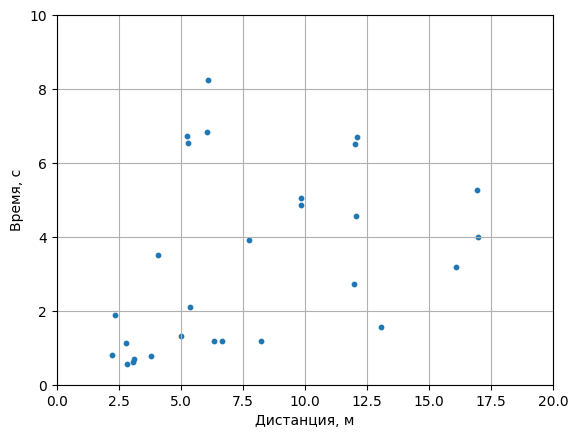

In [1]:
import matplotlib.pyplot as plt
import numpy as np

a = np.array([0.573, 2.811,
1.122, 2.805,
1.182, 8.211,
3.183, 16.084,
0.764, 3.799,
1.171, 6.327,
4.008, 16.985,
5.281, 16.938,
0.616, 3.058,
1.315, 5.009,
8.243, 6.083,
6.838, 6.040,
1.874, 2.326,
0.802, 2.225,
6.740, 5.263,
3.501, 4.089,
1.188, 6.676,
3.911, 7.765,
6.531, 5.287,
2.110, 5.367,
0.691, 3.128,
4.572, 12.070,
5.058, 9.851,
4.872, 9.848,
2.715, 11.972,
1.555, 13.071,
6.715, 12.110,
6.508, 12.012]).reshape(-1, 2)
plt.scatter(a[:, 1], a[:, 0], s=10)
plt.ylabel('Время, с')
plt.xlabel('Дистанция, м')
plt.grid()
plt.ylim(0, 10)
plt.xlim(0, 20)

In [142]:
np.array([
11.3,
12.1,
11.4,
15.6,
13.3,
13.3,
11.0,
12.7,
14.4,
11.5]).mean()

12.66

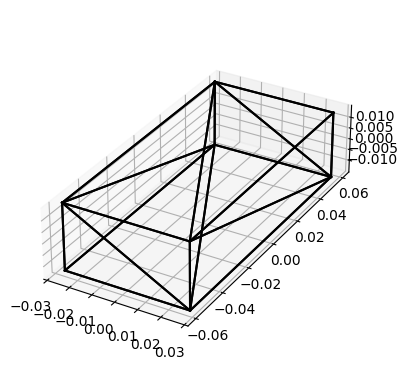

In [25]:
from skspatial.objects import Triangle

l, w, h = 5.5000e-02/2, 1.1458e-01/2, 2.9792e-02/2

mesh = [Triangle([-l, -w, -h], [-l, -w, h], [-l, w, -h]),
        Triangle([-l, w, h], [-l, -w, h], [-l, w, -h]),
        
        Triangle([l, -w, -h], [l, -w, h], [l, w, -h]),
        Triangle([l, w, h], [l, -w, h], [l, w, -h]),
        
        Triangle([l, w, h], [-l, w, h], [l, w, -h]),
        Triangle([-l, w, -h], [-l, w, h], [l, w, -h]),
        
        Triangle([l, -w, h], [-l, -w, h], [l, -w, -h]),
        Triangle([-l, -w, -h], [-l, -w, h], [l, -w, -h]),
        
        Triangle([l, w, h], [-l, w, h], [l, -w, h]),
        Triangle([-l, -w, h], [-l, w, h], [l, -w, h]),
        
        Triangle([l, w, -h], [-l, w, -h], [l, -w, -h]),
        Triangle([-l, -w, -h], [-l, w, -h], [l, -w, -h])]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for tri in mesh: tri.plot_3d(ax, part='lines', c='k')
ax.set_aspect('equal')

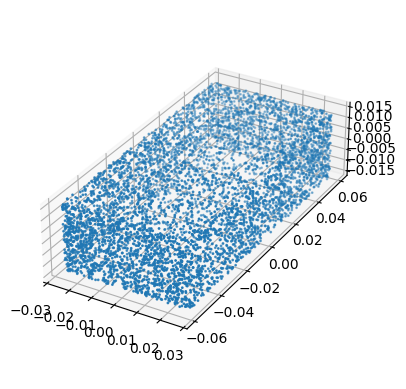

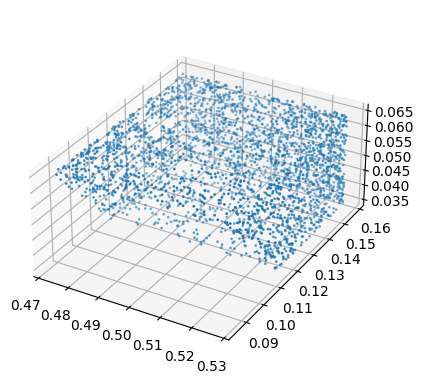

In [55]:
from simpleicp import PointCloud, SimpleICP
import numpy as np
import warnings

# Read point clouds from xyz files into n-by-3 numpy arrays
X_fix: np.ndarray = np.load("brickPC.npy")
X_mov: np.ndarray = np.load("brickPC2.npy")
X_mov = X_mov[X_mov[:, 1] + X_mov[:, 2] > 0] + np.array([0.5, 0.1, 0.05])

# Create point cloud objects
pc_fix = PointCloud(X_fix, columns=["x", "y", "z"])
pc_mov = PointCloud(X_mov, columns=["x", "y", "z"])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X_fix.transpose(), s=1)
ax.set_aspect('equal')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X_mov.transpose(), s=1)
ax.set_aspect('equal')

In [56]:

# Create simpleICP object, add point clouds, and run algorithm!
icp = SimpleICP()
icp.add_point_clouds(pc_fix, pc_mov)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    H, X_mov_transformed, rigid_body_transformation_params, distance_residuals = icp.run(max_overlap_distance=1, max_iterations=100)

Consider partial overlap of point clouds ...
Select points for correspondences in fixed point cloud ...
Estimate normals of selected points ...
Start iterations ...
iteration | correspondences | mean(residuals) |  std(residuals)
   orig:0 |             525 |          0.0180 |          0.0948
        1 |             524 |         -0.0012 |          0.0359
        2 |             656 |         -0.0007 |          0.0189
        3 |             656 |         -0.0004 |          0.0142
        4 |             670 |         -0.0014 |          0.0153
        5 |             801 |         -0.0007 |          0.0202
        6 |             803 |         -0.0004 |          0.0150
        7 |             803 |         -0.0003 |          0.0135
        8 |             802 |         -0.0002 |          0.0128
        9 |             780 |          0.0001 |          0.0121
       10 |             711 |         -0.0002 |          0.0105
       11 |             724 |         -0.0007 |          0.0103
   

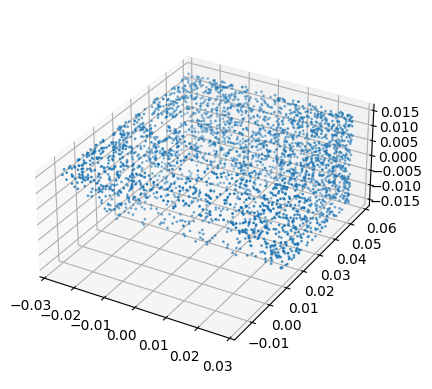

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X_mov_transformed.transpose(), s=1)
ax.set_aspect('equal')

1.0502482345145439

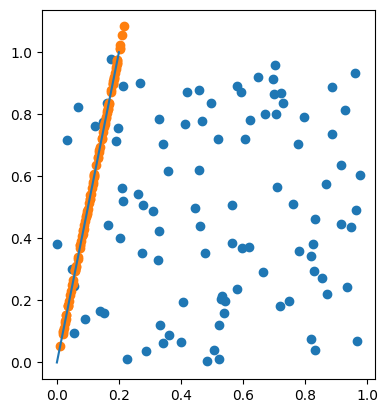

In [65]:
from skspatial.objects import Line

cloud = np.random.random((2, 100))
line = Line.from_points([0, 0], [0.2, 1])
projected = line.project_points(cloud.transpose()).transpose()

mins, maxs = np.min(projected, axis=1), np.max(projected, axis=1)

fig = plt.figure()
ax = fig.add_subplot(111)
line.plot_2d(ax)
plt.scatter(*cloud)
plt.scatter(*projected)
plt.gca().set_aspect('equal')
np.linalg.norm(maxs-mins)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


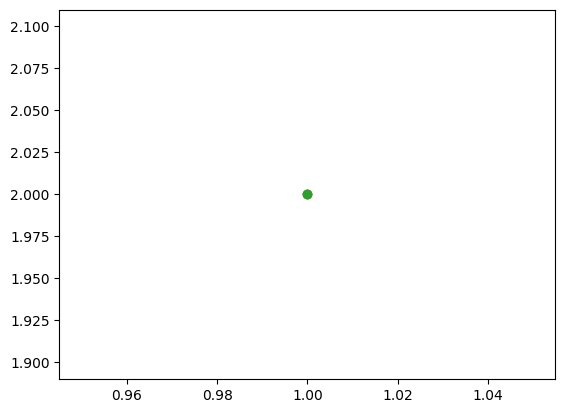

In [8]:
def rotate2D(origin: tuple[float, float], cloud: np.ndarray, angle: float) -> np.ndarray:
    assert cloud.shape[0] == 2, 'wrong input shape'

    ox, oy = origin
    px, py = cloud

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return np.array([qx, qy])

pos = np.array([1., 2.])
rot = 0.
dist = np.array([.3, 0.])

target1 = rotate2D(tuple(pos), dist, np.pi/2-rot) # type: ignore
target2 = rotate2D(tuple(pos), dist, np.pi/2+rot) # type: ignore

plt.scatter(*pos)
plt.scatter(*target1)
plt.scatter(*target2)